Link to Github: https://us02web.zoom.us/rec/share/G1pPAkLAE-ULAl053mthAaaZLoAg597PsiSo9xaWclZaSaEr2-CsHlvFNNWF927H.ujo-Fl1lpsAv8l3g?startTime=1687911105000
Passcode: P%Uwy$8R

#### Completed by Josh Forster and Ben Inbar

#### Assignment Prompt

Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?

In [94]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import json
import math
import seaborn as sns

#### Loading Ratings and Movies Dataset
* Originally exported from TMDB API and uploaded to [Kaggle](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset)
* It is a listing of movies within the TMDB database along with relevant metadata including basic informational items on the films as well as an average score
* use linkage table to combine ratings with movie information

In [91]:
ratings = pd.read_csv('./archive-2/ratings_small.csv')
print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


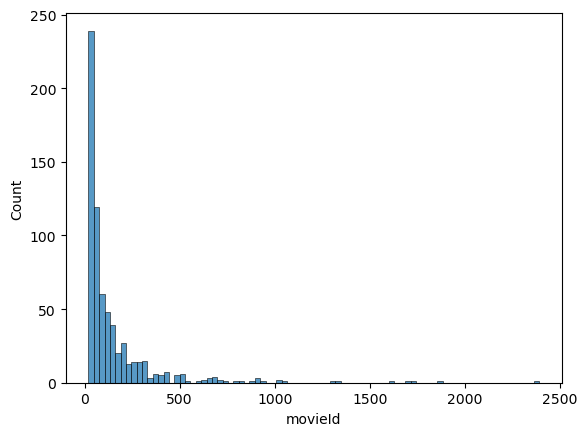

In [12]:
sns.histplot(ratings.groupby('userId')['movieId'].count().sort_values(ascending=False))
plt.show();

In [13]:
ratings['userId'].describe()

count    100004.000000
mean        347.011310
std         195.163838
min           1.000000
25%         182.000000
50%         367.000000
75%         520.000000
max         671.000000
Name: userId, dtype: float64

In [90]:
links = pd.read_csv('./archive-2/links.csv')
links['tmdbId'] = links['tmdbId'].apply(lambda x: str(x).split('.')[0]).astype(str)
print(links.shape)
links.head()

(45843, 3)


,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [4]:
links.dtypes

movieId     int64
imdbId      int64
tmdbId     object
dtype: object

In [92]:
movies = pd.read_csv('./archive-2/movies_metadata.csv')
print(movies.shape)
movies.head()

(45466, 24)


/var/folders/d5/98xjjxvs53s2lf63ml40f_sc0000gn/T/ipykernel_4012/3115494357.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('./archive-2/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [7]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [8]:
movies.genres.isnull().sum()

0

#### Testing parsing json field

In [99]:
#pd.io.json.json_normalize(movies.genres.apply(json.loads))
pd.DataFrame(pd.json_normalize(movies.genres))

""
0
1
2
3
4
...
45461
45462
45463
45464


In [93]:
movies['genres'].apply(pd.Series)

,0
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'id': 35, 'name': 'Comedy'}]"
...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n..."
45462,"[{'id': 18, 'name': 'Drama'}]"
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
45464,[]


#### Manual Parsing of Genres

In [118]:
re.sub('[^\w]','',[x.split(':') for x in movies.iloc[0,3].split(',')][1][1])

'Animation'

In [172]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

#### Manual Review of "Blank" Genres

In [122]:
movies[movies['genres']=='[]']['id'].count()

2442

#### Creating Genre Field

In [9]:
movies['genre'] = movies['genres'].apply(lambda x:\
                                         re.sub('[^\w]','',[item.split(':') for item in x.split(',')][1][1])\
                                         if x!='[]' else 'None')
movies.groupby('genre')['id'].count().sort_values(ascending=False)

genre
Drama             11966
Comedy             8820
Action             4489
Documentary        3415
Horror             2619
None               2442
Crime              1685
Thriller           1665
Adventure          1514
Romance            1191
Animation          1124
Fantasy             704
ScienceFiction      647
Mystery             554
Family              524
Music               487
Western             451
TVMovie             390
War                 379
History             279
Foreign             118
17161                 1
2883                  1
11176                 1
Name: id, dtype: int64

#### Merge Ratings with Links and Movies Inputs

In [10]:
subset_movies = movies[['id','imdb_id','original_title','revenue','runtime','vote_count','vote_average','genre']]
movie_ratings = pd.merge(pd.merge(ratings,links,how='inner',left_on='movieId',right_on='movieId'),\
                         subset_movies,how='inner',left_on='tmdbId',right_on='id')
print(movie_ratings.shape)
movie_ratings.head()

(99850, 14)


,userId,movieId,rating,timestamp,imdbId,tmdbId,id,imdb_id,original_title,revenue,runtime,vote_count,vote_average,genre
0,1,31,2.5,1260759144,112792,9909,9909,tt0112792,Dangerous Minds,180000000.0,99.0,249.0,6.4,Drama
1,7,31,3.0,851868750,112792,9909,9909,tt0112792,Dangerous Minds,180000000.0,99.0,249.0,6.4,Drama
2,31,31,4.0,1273541953,112792,9909,9909,tt0112792,Dangerous Minds,180000000.0,99.0,249.0,6.4,Drama
3,32,31,4.0,834828440,112792,9909,9909,tt0112792,Dangerous Minds,180000000.0,99.0,249.0,6.4,Drama
4,36,31,3.0,847057202,112792,9909,9909,tt0112792,Dangerous Minds,180000000.0,99.0,249.0,6.4,Drama


#### Review null values

In [11]:
movie_ratings.isnull().sum()

userId            0
movieId           0
rating            0
timestamp         0
imdbId            0
tmdbId            0
id                0
imdb_id           0
original_title    0
revenue           0
runtime           0
vote_count        0
vote_average      0
genre             0
dtype: int64

Only the movies/ratings in common are included for purposes of this analysis given the focus on bipartite data with ties between groups. The projected value will indicate false for connections whenever there is not one minimum connection between the two node groups

#### Prepare the projected edges with weights based on ratings

In [13]:
edges_prep = list(zip(movie_ratings.userId,movie_ratings.original_title,movie_ratings.rating))

#### Prepare graph object with movie ratings data

In [16]:
#https://stackoverflow.com/questions/35472402/how-do-display-bipartite-graphs-with-python-networkx-package
B = nx.Graph()
B.add_nodes_from(movie_ratings['original_title'].values, bipartite=0)
B.add_nodes_from(movie_ratings['userId'].values, bipartite=1)
B.add_weighted_edges_from(edges_prep)

top,bottom = nx.bipartite.sets(B)
#pos = nx.bipartite_layout(B, top)
#nx.draw(B, with_labels=True)
#plt.show()

In [17]:
nx.is_connected(B)

True

In [ ]:
#takes long time to run and plots a hairball
nx.draw_networkx(B,with_labels=True)

As we can see from this graph there is a massive hairball visible with a dense cluster of connections that exist for this dataset and incorporating some type of filtering is a must to be able to do any real analysis or identify discernable patterns.

#### Build Projected Graphs with weightings

In [18]:
start = time.time()
mov_weighted_graph=bipartite.weighted_projected_graph(B,list(movie_ratings['original_title'].values))
total_time = time.time() - start

In [89]:
total_time/(60)

21.450670969486236

It took my local machine 21 minutes to build the weighted projections given the large number of edges that were drawn on. After more thought it makes more sense given the anonymity of the user ratings to graph the nodes as the movie titles to be able to analyze the genres or other movie attributes available.|

#### Basic Graph Attributes

In [19]:
print('Nodes:',mov_weighted_graph.number_of_nodes(),r'; Edges:',mov_weighted_graph.number_of_edges())

Nodes: 8786 ; Edges: 10602894


#### Utilize the weighted filtering process from the SNA textbook

In [20]:
def trim_edges(g, weight = 1):
    ''' Pare down number of edges based on parameterized weight criteria'''
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight']> weight:
            x = float(edata['weight'])
            edges.append((f,to,x))
    g2.add_weighted_edges_from(edges)
    return g2


def island_method(g, iterations=5):
    '''
    Social Network Analysis Textbook Method for isolating 
    biggest components of a network  by using centrality criteria to show most dense clusters'''
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    
    #size of step
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

#### Create Subgraph Components

In [21]:
cc_mov = (mov_weighted_graph.subgraph(c) for c in nx.connected_components(mov_weighted_graph))

Due to the older python/networkx version of the textbook utilized some updates found on [SO](https://stackoverflow.com/questions/61154740/attributeerror-module-networkx-has-no-attribute-connected-component-subgraph) although this dataset did not ultimately divide into many smaller subcomponents. That might make sense given that many of the most popular movies transcend demographics and segments.

#### Run Island Method Filtering

In [22]:
rating_islands = island_method(mov_weighted_graph)

#### Review divided subgraphs based on weight filtering

In [87]:
tab_islands = []
for i in rating_islands:
    tab_islands.append([i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1])])
pd.DataFrame(tab_islands,columns=["Threshold", "Nodes", "Edges", "Number of Connected Components"])

,Threshold,Nodes,Edges,Number of Connected Components
0,1,5869,3825520,1
1,47,357,10890,1
2,93,103,992,1
3,139,37,133,1
4,185,8,11,2


The filtering threshold must be higher than 1 given that there are still a large number of nodes and 3.8 million edges remaining after the first iteration of the island method. Therefore, we will review the remaining filter criteria (islands created) to determine which optimal level of "flooding" is necessary to assist with the analysis.

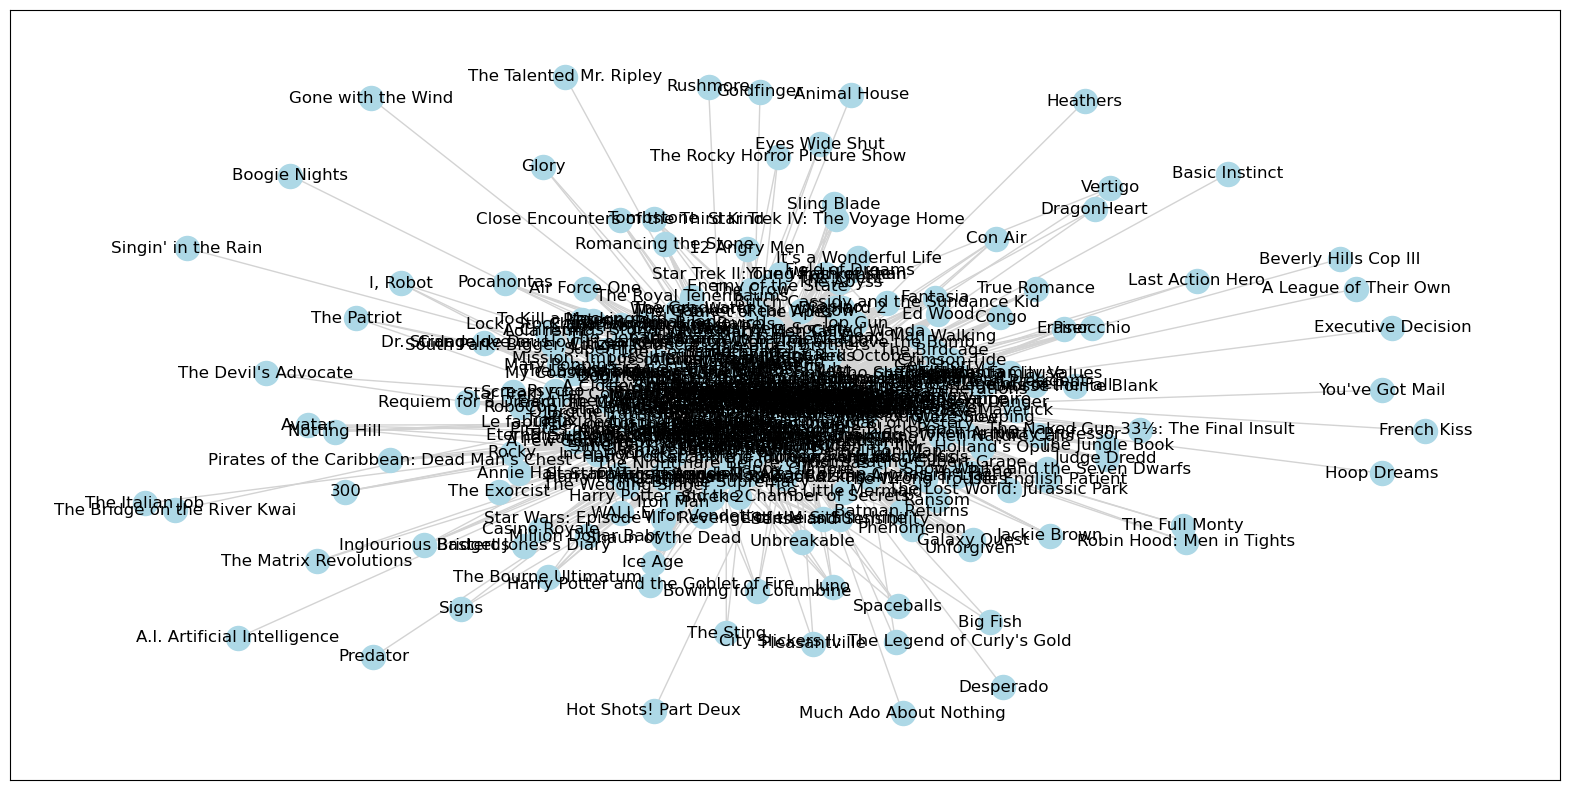

In [215]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'text.usetex':False,'font.family':'stixgeneral','mathtext.fontset':'stix'})
#SO guidance for text bug: https://stackoverflow.com/questions/47253462/matplotlib-mathtext-glyph-errors-in-tick-labels
nx.draw_networkx(rating_islands[1][1],node_color='lightblue',edge_color='lightgray',with_labels=True)

The next threshold of 47 still maintains a fairly dense hairball, which would indicate that some of the more popular movies are not clearly identfiable just yet. Some of the movie titles can be made out and appear to be somewhat well known, but it would be easier to apply a larger weight criteria

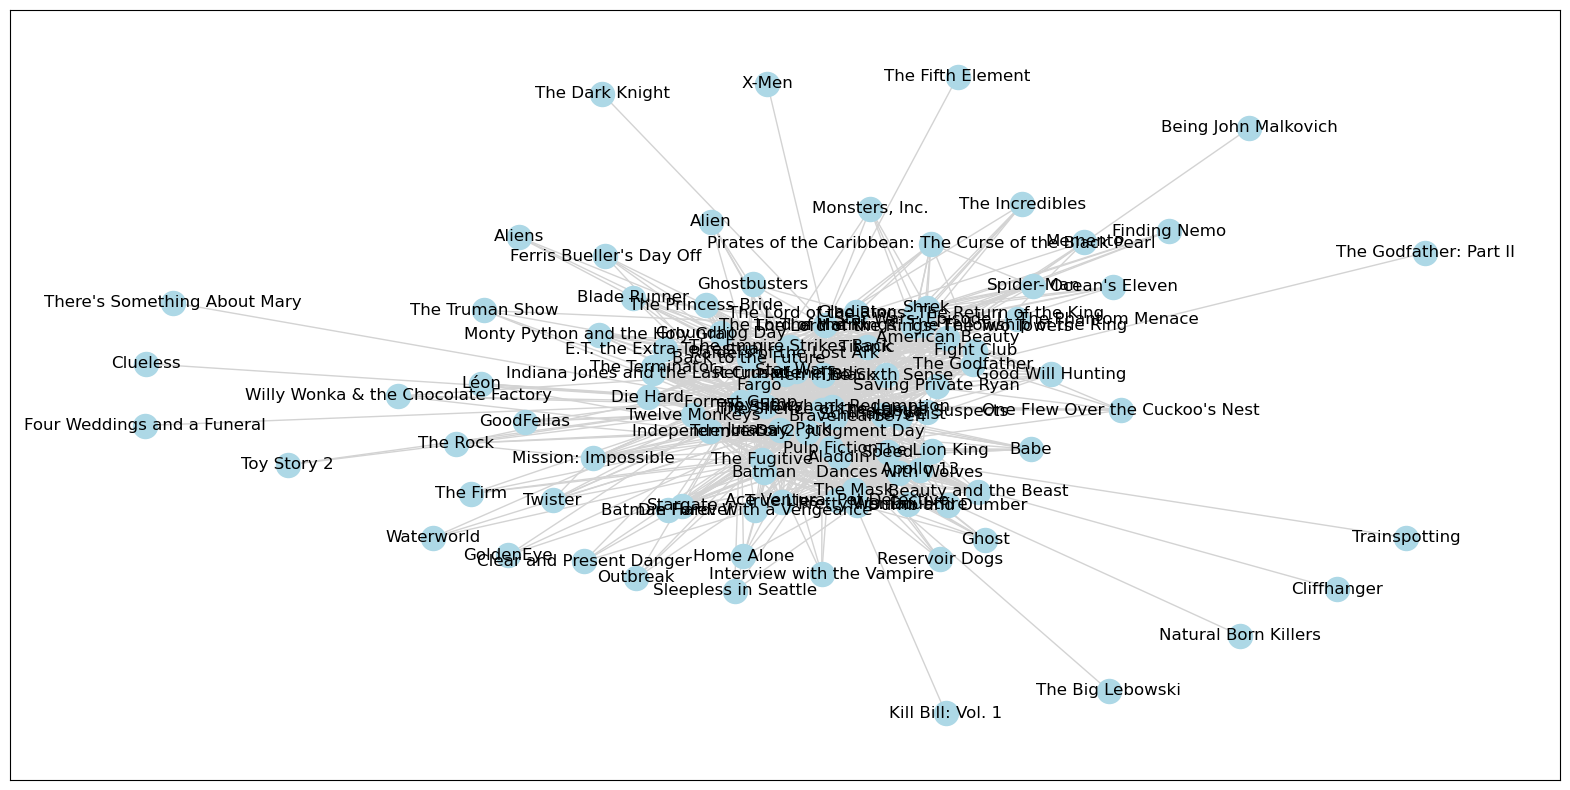

In [202]:
plt.rcParams['figure.figsize'] = [20, 10]
rat_weights = [math.log(float(edata['weight'])) for f, t, edata in rating_islands[2][1].edges(data=True)]
#nx.draw_networkx(G,with_labels=True, edgecolors='blue', node_color='gray', node_size=50)
nx.draw_networkx(rating_islands[2][1],node_color='lightblue',edge_color='lightgray',with_labels=True)

Moving onto the next iteration it appears that the movies that pop out the most are well known classics and generational favorites. Franchise movies make the biggest impressions in this graph as it makes sense that these series of films are incredibly popular and reviewed given that studios would not produce multiple movies about the same story without fan excitement. 

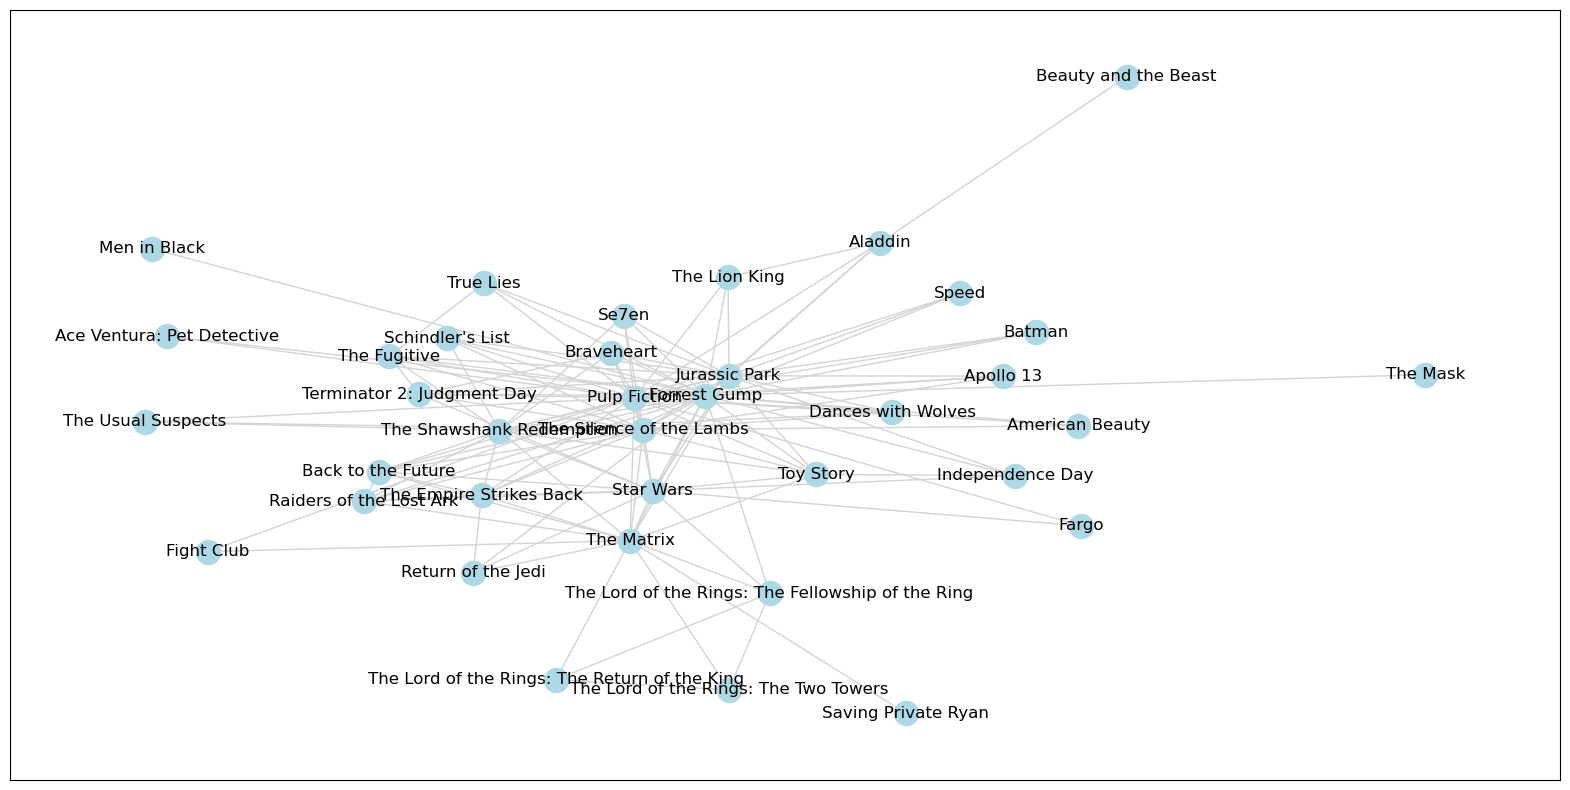

In [201]:
plt.rcParams['figure.figsize'] = [20, 10]
rat_weights = [math.log(float(edata['weight'])) for f, t, edata in rating_islands[3][1].edges(data=True)]
nx.draw_networkx(rating_islands[3][1],node_color='lightblue',edge_color='lightgray',with_labels=True)
plt.show();

This iteration is likely the clearest graph that contains more franchises (e.g. Lord of the Rings, Men in Black, Back to the Future, Star Wars, Disney classics) that have tremendous brand name recognition. There are other one off movies that are popular as well, but if someone had to predict the most popular movies many of these films would be guessed by an average person.

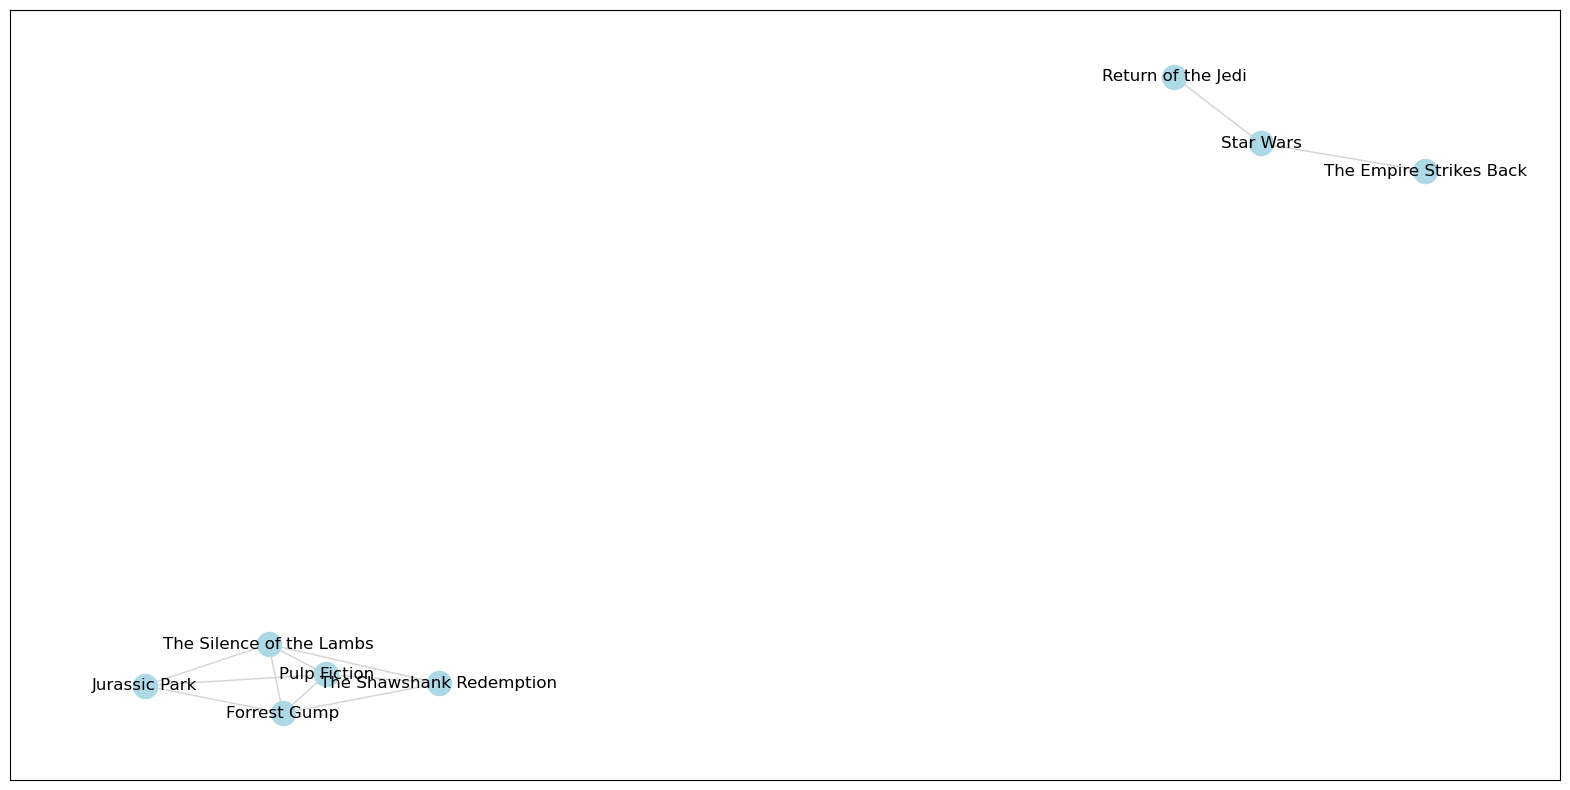

In [200]:
plt.rcParams['figure.figsize'] = [20, 10]
nx.draw_networkx(rating_islands[4][1],node_color='lightblue',edge_color='lightgray',with_labels=True)
plt.show();

The last filtered values show two small separate graphs that include all time classic movies and Star Wars which continues to have spin offs made to this day despite the age of the franchise. This level of weight filtering is likely too high given the limited remaining nodes.

#### Prepare Island SubGraph Centrality

In [242]:
central_list = pd.DataFrame()
for idx,i in enumerate(rating_islands):
    if idx ==3:
        pass
    #central_list[str(idx+1)] = [nx.degree_centrality(i[1])]
    #central_list.append({k:v for k,v in dict(nx.degree_centrality(i[1])).items()})
    central_list = pd.concat([central_list,\
                              pd.DataFrame(list(zip(str(idx+1)*len(nx.degree_centrality(i[1]).keys()),\
                                                    nx.degree_centrality(i[1]).keys(),\
                                                    nx.degree_centrality(i[1]).values())),\
                                           columns=['Iteration','Title','Centrality'])])

In [247]:
print(central_list.shape)
central_list.reset_index(inplace=True)

(6374, 3)


In [249]:
central_list[central_list['Iteration']=='1'].sort_values(by=['Centrality'],ascending=False)

,index,Iteration,Title,Centrality
1140,1140,1,Forrest Gump,0.911554
719,719,1,Back to the Future,0.898262
1827,1827,1,Pulp Fiction,0.883947
1580,1580,1,The Matrix,0.877641
1831,1831,1,The Silence of the Lambs,0.875085
...,...,...,...,...
5863,5863,1,Step Into Liquid,0.000170
5865,5865,1,Stag,0.000170
5611,5611,1,Here On Earth,0.000170
5867,5867,1,The Twilight Saga: Breaking Dawn - Part 1,0.000170


#### Adding sequential group counter

In [251]:
central_list = pd.merge(central_list,pd.DataFrame(central_list.sort_values(['Iteration','Centrality'],ascending=[True,False]).groupby(['Iteration'])['Title'].cumcount(),columns=['seq']),how='left',left_index=True,right_index=True)
central_list.shape

(6374, 5)

#### Bring in Genre for further analysis

In [253]:
genre_df_full = pd.merge(central_list,movie_ratings.groupby(['original_title','genre'])['id'].count().reset_index(),how='inner',left_on='Title',right_on='original_title')
genre_df_full.groupby(['Iteration','genre'])['Centrality'].mean()
genre_df_full.head()


,index,Iteration,Title,Centrality,seq,original_title,genre,id
0,0,1,Dangerous Minds,0.335719,1510,Dangerous Minds,Drama,42
1,1,1,The Substitute,0.080948,4104,The Substitute,Action,10
2,2,1,"Honey, I Shrunk the Kids",0.671950,192,"Honey, I Shrunk the Kids",Adventure,76
3,252,2,"Honey, I Shrunk the Kids",0.061798,220,"Honey, I Shrunk the Kids",Adventure,76
4,3,1,V for Vendetta,0.518746,583,V for Vendetta,Action,73


In [187]:
genre_df_full.groupby(['Iteration','genre'])['Centrality'].mean().reset_index().rename({'0':'Centrality'})

,Iteration,genre,Centrality
0,1,Action,0.226332
1,1,Adventure,0.294911
2,1,Animation,0.217715
3,1,Comedy,0.221687
4,1,Crime,0.260942
...,...,...,...
61,5,Adventure,0.250000
62,5,Comedy,0.571429
63,5,Crime,0.571429
64,5,Drama,0.428571


In [266]:
genre_top25 = genre_df_full[(genre_df_full['seq']<=15) & (genre_df_full['Iteration']).isin(['2','3','4','5'])]

In [278]:
genre_top25.groupby(['Iteration','genre'])['Centrality'].mean().reset_index().sort_values(by=['Iteration','Centrality'],ascending=[True,False])

,Iteration,genre,Centrality
3,2,Comedy,0.876404
6,2,Thriller,0.794944
1,2,Adventure,0.705056
4,2,Crime,0.679775
2,2,Animation,0.668539
5,2,Drama,0.650281
0,2,Action,0.619382
10,3,Comedy,0.843137
13,3,Thriller,0.764706
11,3,Crime,0.637255


#### Graphing the genre's with the highest centrality across filters

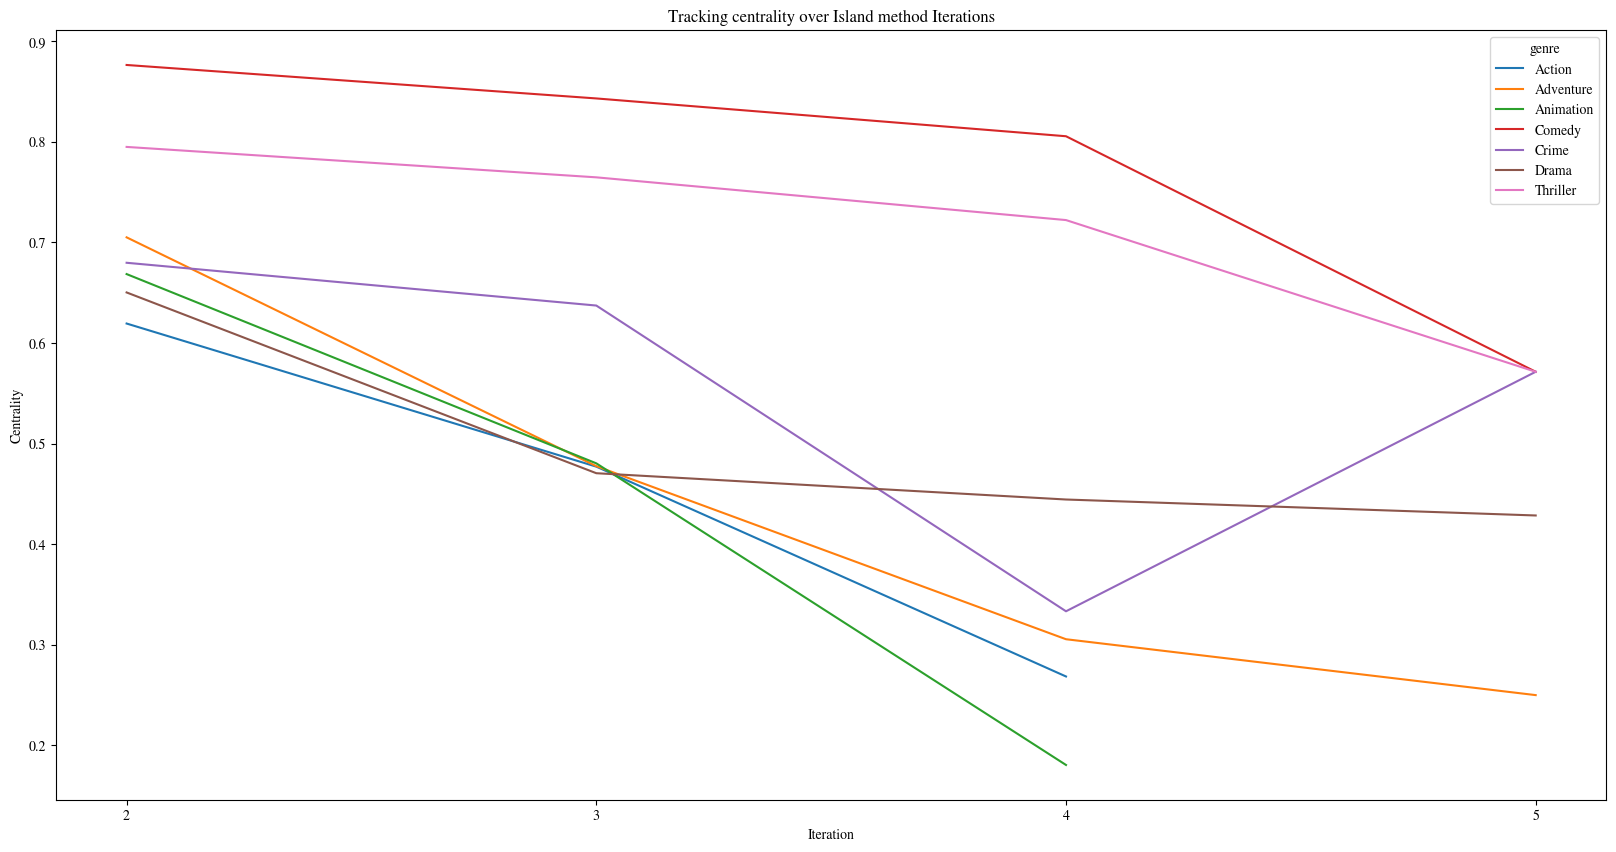

In [279]:
sns.lineplot(data=genre_top25.groupby(['Iteration','genre'])['Centrality'].mean().reset_index().rename({'0':'Centrality'}),x='Iteration',y='Centrality',hue='genre')\
.set_title('Tracking centrality over Island method Iterations')

plt.show();

From reviewing the visual there are a few genres that on average appear to garner very favorable reviews across the applicable weight filter range. Comedies and Thrillers were well reviewed genres that tended to obtain substantial number of positive feedback from their viewers.